<link rel="stylesheet" type="text/css" media="all" href="style.css" />

# Basic format for learning algorithm design

Our setup for designing learning machines has two basic parts: a __model object__ and an __algorithm object__. These are implemented as follows.

 - Model: a class object which contains data (training and testing), model-specific loss functions, gradients, separate evaluation functions.
 - Algorithm: an iterator (also a class object) which is passed an initial point, a model, and various algorithm-specific parameters that control how to update and for how long

In this lesson, we take a detailed look at the *algorithm side only*, leaving the model abstract.

__Contents:__

- <a href="#trivial">Implementing a trivial algorithm</a>
- <a href="#nontrivial">Implementing a non-trivial algorithm</a>
- <a href="#testNoisyOpt">Testing using simulated data: "noisy optimization"</a>
- <a href="#GD">Updates using gradient information</a>
- <a href="#SGD">Updates using stochastic sub-sampling</a>

___



<a id="trivial"></a>
## Implementing a trivial algorithm

As a very simple initial example, let us assume that we only have access to a loss function, and implement a gradient descent routine using finite-difference approximations of the partial derivatives.

Definition (and implementation) of a trivial iterator:

In [1]:
class Algo_trivial:

    '''
    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    '''

    def __init__(self, w_init, t_max):
        
        self.w = np.copy(w_init)
        self.t_max = t_max


    def __iter__(self):

        self.t = 0
        print("(__iter__): t =", self.t)

        return self
    

    def __next__(self):

        # Condition for stopping.
        
        if self.t >= self.t_max:
            print("--- Condition reached! ---")
            raise StopIteration

        print("(__next__): t =", self.t)
        self.w *= 2
        self.t += 1

        # Note that __next__ does not need to return anything.

    def __str__(self):

        out = "State of w:" + "\n" + "  " + str(self.w)
        return out


Let's observe how it behaves.

In [2]:

import numpy as np

al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

print("Printing docstring:")
print(al.__doc__) # check the docstring (not)

for mystep in al:
    pass # do nothing special


Printing docstring:

    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    
(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3
(__next__): t = 4
(__next__): t = 5
(__next__): t = 6
(__next__): t = 7
(__next__): t = 8
(__next__): t = 9
--- Condition reached! ---


Key points:

 - After the `StopIteration` exception is raised, immediately exit the for loop.
 - At the "zeroth" step, both `iter` and `next` are called.

Note above that the `for` loop is just doing the following operations for us.

In [3]:
iter(al)
next(al)
next(al)
next(al)
next(al) # and so on...

(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3


In [4]:

al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

for mystep in al:
    print(al) # useful for monitoring state.

print("One last check after exiting:")
print(al) # ensure that no additional changes were made.

(__iter__): t = 0
(__next__): t = 0
State of w:
  [ 2  4  6  8 10]
(__next__): t = 1
State of w:
  [ 4  8 12 16 20]
(__next__): t = 2
State of w:
  [ 8 16 24 32 40]
(__next__): t = 3
State of w:
  [16 32 48 64 80]
(__next__): t = 4
State of w:
  [ 32  64  96 128 160]
(__next__): t = 5
State of w:
  [ 64 128 192 256 320]
(__next__): t = 6
State of w:
  [128 256 384 512 640]
(__next__): t = 7
State of w:
  [ 256  512  768 1024 1280]
(__next__): t = 8
State of w:
  [ 512 1024 1536 2048 2560]
(__next__): t = 9
State of w:
  [1024 2048 3072 4096 5120]
--- Condition reached! ---
One last check after exiting:
State of w:
  [1024 2048 3072 4096 5120]


### Exercises:

 1. Modify `Algo_trivial` such that $w$ is doubled at each iteration.
 1. Furthermore, modify the parameters passed to `al` such that we start at $w=(0,1,2,3,4)$ and end when $w=(0, 16, 32, 48, 64) = (0 \times 2^4, 1 \times 2^4, 2 \times 2^4, 3 \times 2^4, 4 \times 2^4)$.
 1. What happens to the state of $w$ if you run the `for` loop multiple times without re-defining `al` each time?
 
___

<a id="nontrivial"></a>
## Implementing a non-trivial algorithm

In the above example, we only specified parameters and an initial value, and updated based on a hard-coded numerical rule. In practice, algorithms should be more flexible than this, and should be able to deal with a wide range of tasks. The following example realizes this.

Assuming that we have some loss function $l(w;z)$ depending on our parameter (and the data), to minimize the mean of the observations $\{l(w;z_{1}),\ldots,l(w;z_{n})\}$ as a function of $w$, one typical strategy is

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{n}\sum_{i=1}^{n} \nabla l(w_{(t)};z_{i}).
\end{align}

If we don't know $\nabla l(\cdot;z)$ however, then such an approach fails. The simplest alternative is to leverage the method of finite differences, well-known since at least the time of Euler. Applying a perturbation to one coordinate at a time,

\begin{align}
\Delta_{j} & = (0,\ldots,\delta,\ldots,0), \text{ such that} \\
w + \Delta_{j} & = (w_{1},\ldots,(w_{j}+\delta),\ldots,w_{d}), \quad j = 1,\ldots,d 
\end{align}

we can take finite differences to approximate the partial derivatives of interest, 

\begin{align}
\widehat{g}_{i,j}(w) & = \frac{l(w+\Delta_{j};z_{i})-l(w;z_{i})}{\delta} \approx \frac{\partial l(w;z_{i})}{\partial w_{j}}, \quad i=1,\ldots,n \\
\widehat{g}_{i}(w) & = \left(\widehat{g}_{i,1}(w),\ldots,\widehat{g}_{i,d}(w)\right), \quad i=1,\ldots,n.
\end{align}

The procedure implemented here simply replaces the true gradients with their finite-difference approximations, evaluated at each point, namely we update using

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{n}\sum_{i=1}^{n} \widehat{g}_{i}(w_{(t)}).
\end{align}

The source code for the implementation of this iterator is as follows. Pay close attention to the method called `update`, as this is precisely where we access the "loss".

In [5]:

class Algo_GD_FiniteDiff:

    '''
    Iterator which implements a line-search steepest descent method,
    via finite differences to approximate the gradient.
    '''

    def __init__(self, w_init, t_max, step, delta, verbose, store):

        # Store the user-supplied information.
        self.w = np.copy(w_init)
        self.t = None
        self.t_max = t_max
        self.step = step
        self.delmtx = np.eye(self.w.size) * delta
        self.delta = delta
        self.verbose = verbose
        self.store = store
        
        # If asked to store, keep record of all updates.
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float64)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        

    def __iter__(self):

        self.t = 0

        if self.verbose:
            print("(via __iter__)")
            self.print_state()
        
        return self

    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()


    def update(self, model):
        
        stepsize = self.step(self.t)
        newdir = np.zeros(self.w.size, dtype=self.w.dtype)
        loss = model.l_tr(self.w)

        # Perturb one coordinate at a time, compute finite difference.
        for j in range(self.w.size):
            
            # Perturb one coordinate. MODEL ACCESS here.
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj))
            
            newdir[j] = np.mean(loss_delta-loss) / self.delta
            
            
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


    def print_state(self):
        print("------------")
        print("t =", self.t, "( max = ", self.t_max, ")")
        print("w = ", self.w)
        print("------------")


The most important point to note is the presence of `l_tr` in the update step. This is a *method* of the model object, passed via the creatively-named `model`, which in turn depends on the data. The correspondence is as follows (on the `j`th iteration):

| `code` | Formal representation |
| ------ | :----------------: |
| `delta` | $\delta$ |
| `delj` | $\Delta_{j}$ |
| `loss` | $\left( l(w;z_{1}), \ldots, l(w;z_{n}) \right)$ |
| `loss_delta` | $\left(l(w+\Delta_{j};z_{1}), \ldots, l(w+\Delta_{j};z_{n})\right)$ |
| `newdir[j]` | $\sum_{i=1}^{n}\widehat{g}_{i,j}(w) / n$ |

Of course, the `model` here is completely abstract at this point; all we assume is that there will be *some* model provided to the learning algorithm at runtime, which holds all the information required to carry out a particular learning task using the desired algorithm. Since the details of such information will inevitably change from problem to problem, this general algorithm class is convenient since after implementing it once, we can re-use it for countless tasks.

A few other secondary points:

 - New arguments: `step`, `delta`, `verbose`, `store`.
 - New methods: `print_state`, `update`.
 - `print_state`: provide state information in an internal fashion.
 - `store`: If True, then save all iterates of the algorithm as an array $[w_{(0)}, \cdots, w_{(T)} ]$ where $T$ corresponds to `t_max`.
 - With this setup, *both the model and algorithm can change dynamically*. That is, if desired, the model may be updated based on $w_{(t)}$ at some $t$, and since the model is passed to the algorithm, this in turn impacts $w_{(t+1)}$ and beyond.
 
To investigate how this algorithm behaves, we must have a model, which requires some data. We prepare some hand-designed data in the next sub-section.

___

<a id="testNoisyOpt"></a>
## Testing using simulated data: "noisy optimization"

Next, let's see how this algorithm behaves on some data by providing a model ourselves. First, let's describe the model. The idea is that our learning task is characterized by minimizing the *risk* (expected loss),

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad R(w) = \mathbf{E}_{Z} l(w;z).
\end{align}

In practice, since the underlying distribution is unknown, all we have available to us is knowledge of $l$, and a set of data points $z_{1},\ldots,z_{n}$.

The example below starts with $R$ taking the simple form of a quadratic function, here denoted by

\begin{align}
R(w) = (w - w^{\ast})^{T}A(w - w^{\ast}) + b^2.
\end{align}

In order for the condition $\mathbf{E}_{Z} l(w;z) = R(w)$ to hold for all $w \in \mathbb{R}^{d}$, one sufficient form of the loss is the squared error under a linear regression model with additive noise, independent of the inputs. That is, $z = (x,y)$ with

\begin{align}
y = \langle w^{\ast}, x \rangle + \varepsilon
\end{align}

and $\mathbf{E}\varepsilon^2 = b^2$, assumed to be independent of each element of random vector $x \in \mathbb{R}^{d}$, such that $\mathbf{E}\varepsilon x = 0$. Expanding the squared term and integrating, it follows that the desired equality holds, with

\begin{align}
A = \mathbf{E}xx^{T}.
\end{align}

In the special case that $\mathbf{E}_{X}x = 0$, we naturally have $A =\text{cov}\,x$. In special cases where both $l$ and $R$ are *known*, then that provides an ideal opportunity to show how random idiosyncracies in the sample can lead to inefficient learning. On the other side of that coin, it also gives us a chance to test when modifications to the learning algorithm can overcome these issues.

We have prepared a function for generating random data according to precisely the model given above in the function called `NoisyOpt_isoBig` in the `support/parse_model` directory. Instead of providing the source (feel free to look), we look directly at its output.

In [6]:
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# Data information used to initialize the model.
data_info = dp.NoisyOpt_isoBig()

print("Data information:")
print(data_info)

Data information:
X_tr: {'shape': (50, 2), 'path': 'data/NoisyOpt_isoBig/X_tr.dat', 'dtype': dtype('float64')}
X_te: None
y_tr: {'shape': (50, 1), 'path': 'data/NoisyOpt_isoBig/y_tr.dat', 'dtype': dtype('float64')}
y_te: None
mname: NoisyOpt
misc: {'cov_X': array([[ 1.,  0.],
       [ 0.,  1.]]), 'sigma_noise': 1, 'nsub': 5, 'w_true': array([[ 3.141592],
       [ 1.414214]]), 'w_init': array([[ 8.141592],
       [ 6.414214]])}


Key points to get down (note that `*_tr` means "training" data, and `*_te` means "test" data):

- At this point in our program, the data has already been generated and written to disk. Re-running the above code will re-generate the data.

```
$ ls -l data/NoisyOpt_isoBig
```

- This data info object contains key information about all our data; e.g., `data_info.X_tr["path"]` contains the path in memory (relative to `learnml`) where the training inputs are.
- The testing data is `None` because we are assuming access to an oracle (of the function $R$) for evaluation; this is provided by the `NoisyOpt` model, which is the model that we have hard-coded this data set to prefer (in `mname`).
- In `misc`, we store all manner of constants that are required to specify the oracle, among other things. For example, `sigma_noise` is $\mathbf{E} \varepsilon^2$, `cov_X` is $\mathbf{E}xx^{T}$, and `w_true` is $w^{\ast}$.
- Note that even if you re-run the above code, all the parameters will be the same; they are hard-coded, but the data, as we will see, is randomly generated every time.

It should be clear that this data set is an implementation of the above model with $n$ and $d$ given by the `shape` of `X_tr`. In particular, $d=2$ is readily confirmed; this is useful because we can easily visualize contour lines of $R$ over the parameter space $\mathbb{R}^2$. Let's actually create a model object now (definitions in `support/models.py` if interested).

In [16]:

mod = mp.model(data_info) # pass the data info.
print("Model information:")
print(mod)
print("checksum:", np.sum(mod.X_tr)) # if re-run the NoisyOpt_isoBig function, naturally data will change.

print("Attributes of the model:")
pp.pprint(dir(mod))


Model information:
MODEL: NoisyOpt.
Info on data as follows...
X_tr:(50, 2)
X_te:None
y_tr:(50, 1)
y_te:None

checksum: -13.8014346642
Attributes of the model:
['X_te',
 'X_tr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cov_X',
 'd',
 'eval',
 'eval2D_helper',
 'evalDist',
 'evalSparsity',
 'g_imp',
 'g_j_imp',
 'g_j_tr',
 'g_tr',
 'l_imp',
 'l_tr',
 'n',
 'nsub',
 'sigma_noise',
 'w_init',
 'w_initialize',
 'w_true',
 'y_te',
 'y_tr']


While most of the attributes are not of interest to us, note that in initializing this model, we have read the data from disk, and are now storing it in memory:

In [17]:
print(type(mod.X_tr), mod.X_tr.shape)
print(type(mod.y_tr), mod.y_tr.shape)

<class 'numpy.ndarray'> (50, 2)
<class 'numpy.ndarray'> (50, 1)


Furthermore, we see the object `l_tr`, which computes the squared error on the training data, which will be critical for actually running our algorithm `Algo_GD_FiniteDiff`. Finally, for evaluation based on the oracle, passing `w` to `eval` returns $R(w)$, and passing `w` to `evalDist` returns $\|w-w^{\ast}\|$.

Let's fully equip our algorithm with the parameters it needs to do some learning. First off, since the step-size parameter $\alpha_{(t)}$ is typically a function of the number of iterations elapsed, we prepare some functions for callback during learning.

In [18]:
def alpha_fixed(t, val):
    '''
    Step-size function: constant.
    '''
    return val

def alpha_log(t, val=1):
    '''
    Step-size function: logarithmic.
    '''
    return val / (1+math.log((1+t)))

def alpha_pow(t, val=1, pow=0.5):
    '''
    Step-size function: polynomial.
    '''
    return val / (1 + t**pow)


# A function for making step-size functions.
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep

With that, we can set some initial value and initialize our algorithm object.

In [19]:
# Initial point.
w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

# Initialize the algorithm object.
al = Algo_GD_FiniteDiff(w_init=w_init,\
                        delta=0.01,\
                        step=make_step(0.2),\
                        t_max=10,\
                        verbose=True,\
                        store=True)

al.print_state()

------------
t = None ( max =  10 )
w =  [[ 0.]
 [ 0.]]
------------


All that remains is to iterate the algorithm until it "sputters out".

In [20]:

# Run the iterative procedure, using model-dependent "update" at each step.
for mystep in al:
    al.update(model=mod)
    
mypath = al.wstore


(via __next__)
------------
t = 0 ( max =  10 )
w =  [[ 0.]
 [ 0.]]
------------
(via __next__)
------------
t = 1 ( max =  10 )
w =  [[ 0.]
 [ 0.]]
------------
(via __next__)
------------
t = 2 ( max =  10 )
w =  [[ 0.8808463 ]
 [ 0.56729953]]
------------
(via __next__)
------------
t = 3 ( max =  10 )
w =  [[ 1.5049427 ]
 [ 0.93127612]]
------------
(via __next__)
------------
t = 4 ( max =  10 )
w =  [[ 1.94954641]
 [ 1.16104494]]
------------
(via __next__)
------------
t = 5 ( max =  10 )
w =  [[ 2.26816196]
 [ 1.30286547]]
------------
(via __next__)
------------
t = 6 ( max =  10 )
w =  [[ 2.4979463 ]
 [ 1.38758525]]
------------
(via __next__)
------------
t = 7 ( max =  10 )
w =  [[ 2.66478501]
 [ 1.43568035]]
------------
(via __next__)
------------
t = 8 ( max =  10 )
w =  [[ 2.78677607]
 [ 1.46066461]]
------------
(via __next__)
------------
t = 9 ( max =  10 )
w =  [[ 2.87662381]
 [ 1.4713923 ]]
------------
(via __next__)
------------
t = 10 ( max =  10 )
w =  [[ 2.943

While numeric convergence can be rather easy to confirm when we only have a few parameters to set, it is generally easier to visualize.

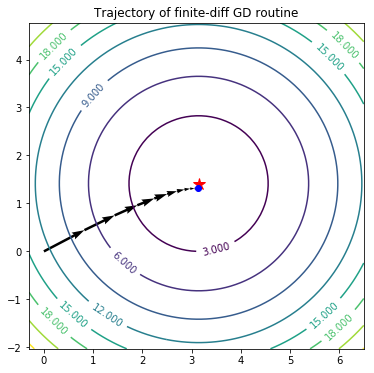

Error of final point: 1.01066141816


In [24]:
import matplotlib
import matplotlib.pyplot as plt



eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)

myfig = plt.figure(figsize=(6,6))
ax = myfig.add_subplot(1,1,1)
CS = ax.contour(X, Y, Z)
ax.quiver(mypath[0,:-1], mypath[1,:-1],
          mypath[0,1:]-mypath[0,:-1],
          mypath[1,1:]-mypath[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='k')
CS.clabel(inline=1, fontsize=10)
ax.plot(*mod.w_true, 'r*', markersize=12) # print true value.
ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
plt.title('Trajectory of finite-diff GD routine')
plt.show()

perf = mod.eval(al.w)
print("Error of final point:", perf)

At the very least, we have confirmed that the algorithm does not behave too differently from how we would hope.

### Exercises:

 1. How does making `w_init` better or worse impact convergence? (note $w^{\ast}=(\pi,e)$ is fixed).
 1. Does setting `delta` differently make a major impact? What is a "safe range"?
 1. Try using data from other distributions (by de-commenting). How does performance change across distribution families?
 1. What about different `step` ($\alpha_{(t)}$) choices? Which strategies work, and when (with respect to data)?
 1. Add a `thres` parameter which tells the algorithm to stop if $\|w_{(t+1)}-w_{(t)}\| \leq \epsilon$, where `thres` specifies $\epsilon$.
 1. (Bonus) Note that we average over the data (the $n$ observations) *__after__* computing the per-point finite difference estimates. An alternative approach is to do it in reverse order: averaging the losses *__before__* we compute differences. How does this approach compare, performance-wise?
 
___

The above example was illustrative of how the algorithm itself behaves, but taking new samples makes things a lot clearer. We do this below.

Error: 1.00765359276
Error: 1.93649726591
Error: 1.12110188449
Error: 1.03247112451
Error: 1.16693002575
Error: 1.00077328932
Error: 1.38502150648
Error: 1.48878454466


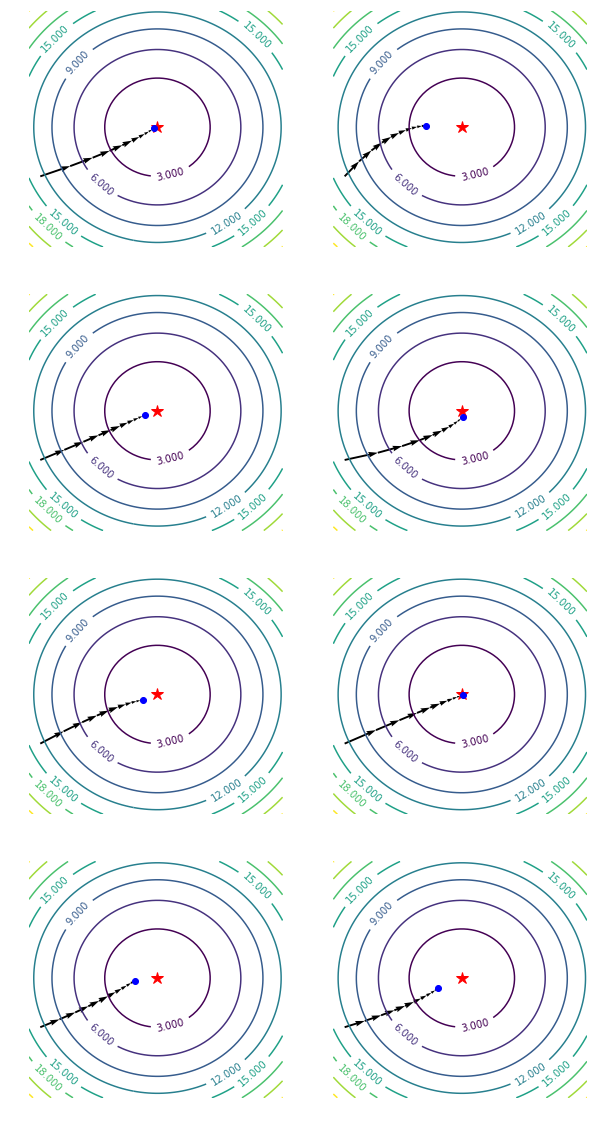

In [25]:

import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

num_trials = 8

w_est_overtrials = {str(i):None for i in range(num_trials)} # initialize

for tr in range(num_trials):
    
    # Generate new data.
    data_info = dp.NoisyOpt_isoBig()
    mod = mp.model(data_info)
    
    # "Run" the algorithm.
    al = Algo_GD_FiniteDiff(w_init=w_init,\
                            delta=0.01,\
                            step=make_step(0.2),\
                            t_max=10,\
                            verbose=False,\
                            store=True)
    for mystep in al:
        al.update(model=mod)
        
    perf = mod.eval(al.w)
    print("Error:", perf)
    
    # Store the algorithm's output (the full trajectory).
    w_est_overtrials[str(tr)] = al.wstore
    

eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)
    
myfig = plt.figure(figsize=(10,20))

grididx = 1
for tr in range(num_trials):
    
    mypath = w_est_overtrials[str(tr)]
    
    ax = myfig.add_subplot(num_trials//2, 2, grididx)
    grididx += 1
    
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12)
    ax.plot(*mypath[:,-1], 'bo', markersize=6)
    ax.axis("off")

plt.show()

Note that each figure above represents the same algorithm run from the same initial point, but with different, independent samples of data each time. Clearly the uncertainty in the data impacts the trajectory of the procedure as it navigates the parameter space. This *approximate optimization* notion is fundamental to machine learning.

A __reliable__ learner should be able to get near the optimal point for virtually all samples (given a distribution). A __robust__ learner should be able to do this for a wide variety of distributions. An __efficient__ learner should be able to do this without requiring too large a sample (i.e., even when $n$ is small).

### Exercises:

1. In the source code of `support/parse_data.py`, search out the definition of `NoisyOpt_isoBig`, and modify the value of `n`, unsurprisingly corresponding to $n$, the number of samples. Change this to a large value, say $n=1000$ or more. Does the algorithm's behaviour change? Also try setting $n$ to very small values.

2. At present, we measure the error achieved by the final estimate in `perf` and just `print` it. Modify the above code such that we store the error for all trials. Compute the average (with $np.mean$) and standard deviation (with $np.sd$) of the error over trials.

(Bonus) The above algorithm implements the *forward difference* approximation of $\nabla l(w;z)$, but this is by no means the only approximation, nor is it the best. For example, we have

\begin{align}
\frac{l(w;z_{i})-l(w-\Delta_{j} ;z_{i})}{\delta} \quad \text{and} \quad \frac{l(w+\Delta_{j};z_{i})-l(w-\Delta_{j};z_{i})}{2\delta}
\end{align}

respectively known as the *backward difference* and *central difference* approximations of the $j$th partial derivative. Modify `Algo_GD_FiniteDiff` or create a new class to implement these two approaches. How do they compare with the original in terms of their trajectory? Their rate of convergence? Their robustness as $n$ becomes small?

___


<a id="GD"></a>
## Updates using gradient information

Let us now "upgrade" our algorithm a bit. Recall that we were working with a loss function $l(w;z)$ whose expected value over the distribution of the data $z$ we seek to minimize, via controllable parameters $w$. Previously, we assumed that the gradient $\nabla l(w;z)$ was unknown. In many cases, however, this can be computed analytically. For example, when $z = (x,y) \in \mathbb{R}^{d+1}$, and we are trying to predict $y$ using a linear model, the squared error $l(w;z) = (y - \langle w,x \rangle)^{2}$ has gradient of

\begin{align}
\nabla l(w;z) = 2(y-\langle w,x \rangle)(-1)x.
\end{align}

Indeed $\nabla l(w;z)$ is often computable even when we use much more complicated models, such as non-linear neural networks. When the gradient can be computed, there is no reason to spend computational resources on approximating it, and the we can carry out the full gradient descent procedure,

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{n}\sum_{i=1}^{n} \nabla l(w_{(t)};z_{i}).
\end{align}

To implement this, given the algorithm class we have already built, is extremely straightforward. We implement this as `Algo_GD` below.

In [31]:
class Algo_GD(Algo_GD_FiniteDiff):

    '''
    Iterator which implements a line-search steepest descent method,
    using the sample mean estimate of the gradient.
    '''

    def __init__(self, w_init, t_max, step, verbose, store):
        
        super(Algo_GD,self).__init__(w_init=w_init, t_max=t_max, step=step,
                                     delta=0, verbose=verbose, store=store)


    def update(self, model):
        
        stepsize = self.step(self.t)
        
        # Instead of finite-difference approximation, simply
        # access the gradient method of our model object.
        newdir = np.mean(model.g_tr(w=self.w),
                         axis=0) # take sample mean to get update direction.
        
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


As before, we access the abstract model object, again creatively called `model`, but this time we make use of the attribute `g_tr`. This `g_tr` is an array of the form $n \times d$, where $d$ is the length of $w$, and it takes the form

\begin{align}
\begin{bmatrix}
\nabla l(w;z_{1})\\
\vdots\\
\nabla l(w;z_{n})
\end{bmatrix}.
\end{align}

Taking the average over columns gives the gradient of the sample mean loss. Let's see how it performs.

Error: 1.23649478881
Error: 1.1412849744
Error: 1.87963118686
Error: 1.18391559627
Error: 1.09642970385
Error: 1.27424503096
Error: 1.68075839056
Error: 1.02583125485


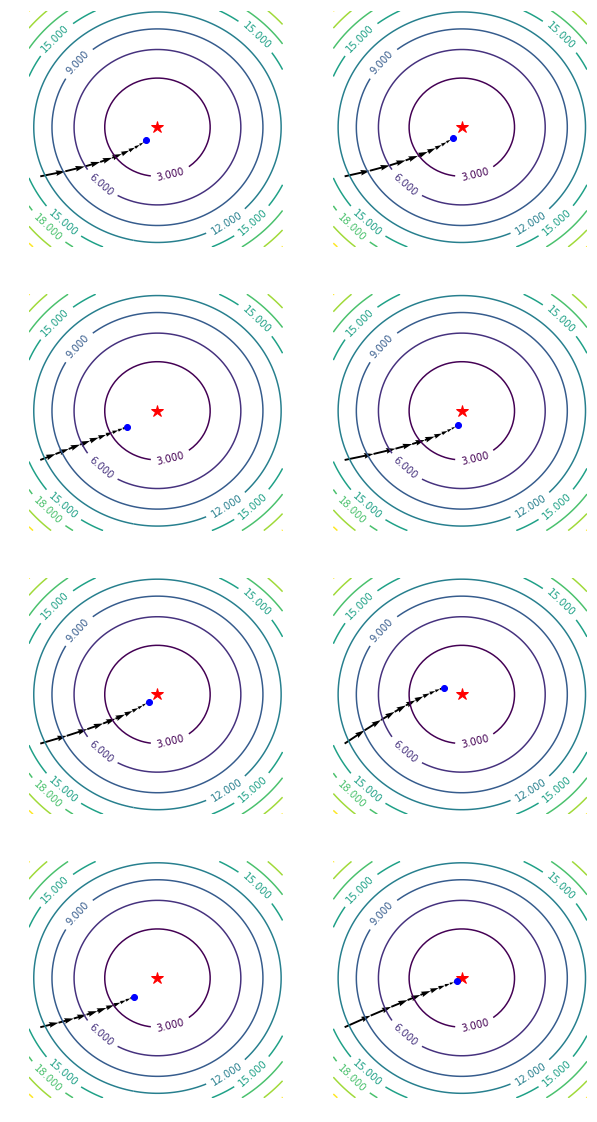

In [32]:

import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

num_trials = 8

w_est_overtrials = {str(i):None for i in range(num_trials)} # initialize

for tr in range(num_trials):
    
    # Generate new data.
    data_info = dp.NoisyOpt_isoBig()
    mod = mp.model(data_info)
    
    # "Run" the algorithm.
    al = Algo_GD(w_init=w_init,\
                 step=make_step(0.2),\
                 t_max=10,\
                 verbose=False,\
                 store=True)
    for mystep in al:
        al.update(model=mod)
        
    perf = mod.eval(al.w)
    print("Error:", perf)
    
    # Store the algorithm's output (the full trajectory).
    w_est_overtrials[str(tr)] = al.wstore
    

eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)
    
myfig = plt.figure(figsize=(10,20))

grididx = 1
for tr in range(num_trials):
    
    mypath = w_est_overtrials[str(tr)]
    
    ax = myfig.add_subplot(num_trials//2, 2, grididx)
    grididx += 1
    
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12)
    ax.plot(*mypath[:,-1], 'bo', markersize=6)
    ax.axis("off")

plt.show()

By using the true gradient, we have eliminated one source of uncertainty in this simple toy learning problem, namely that of the approximation of the true gradient; that error is now zero. That said, since we only have a finite sample and do not know the true objective function, we see that the algorithm still may converge to a sub-optimal point.

### Exercises:

1. Just as before, modify the above code such that the final error achieved per trial is recorded, and compute the average and standard deviation of the error over trials.

1. How does the average error compare with the finite-difference case? At what level of $\delta$ does `Algo_GD_FiniteDiff` provide a sufficient alternative to the true `Algo_GD`? Compare them with identical step sizes, both large and small.

This gradient descent routine is ubiquitous throughout machine learning. Depending on the specific problem at hand, one or more variants of this core technique may be used. Perhaps the simplest of these variants is to use randomly selected sub-samples---a few random points---instead of computing all $nd$ partial derivatives. We consider this stochastic approximation next.

<a id="SGD"></a>
## Updates using stochastic sub-sampling

When we have many controllable parameters $w=(w_{1},\ldots,w_{d})$, that means that we must compute many partial derivatives in order to acquire the gradient of the loss evaluated at any given point. When we have $n$ observations and large $d$, this can be computationally prohibitive in an iterative scheme such as the one explored above. One way around this is to take a random sub-sample of the data, often called a *mini-batch*, and to run standard gradient descent on this smaller set. That is, we randomly choose indices

\begin{align}
\mathcal{I} \subset \{1,2,\ldots,n\}
\end{align}

with size $|\mathcal{I}| = B$. We then compute the mini-batch gradient

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{B}\sum_{j \in \mathcal{I}} \nabla l(w_{(t)};z_{j}).
\end{align}

The classical case is where $B=1$, and is typically considered the canonical form of *stochastic gradient descent* (SGD). More generally, say each $i \in \mathcal{I}$ is sampled independently and uniformly from $\{1,\ldots,n\}$, then taking expectation with respect to these random indices, for any $w$,

\begin{align}
\mathbf{E} \left( \frac{1}{B}\sum_{i \in \mathcal{I}} \nabla l(w;z_{i}) \right) & = \frac{1}{B}\sum_{i \in \mathcal{I}} \mathbf{E} \nabla l(w;z_{i})\\
 & = \frac{1}{B}\sum_{j \in \mathcal{I}}\left(\frac{1}{n} \sum_{i=1}^{n} \nabla l(w;z_{j}) \right)\\
 & = \frac{1}{n} \sum_{i=1}^{n} \nabla l(w;z_{j}).
\end{align}

That is, the expected value of this random quantity the "full gradient" itself. The hope is that after a sufficient number of inexpensive iterations, this variance will iron itself out. Let's implement this it to see how the algorithm behaves first-hand.

In [33]:
class Algo_SGD(Algo_GD_FiniteDiff):

    '''
    Iterator which implements a line-search steepest descent method,
    using the sample mean estimate of the gradient.
    '''

    def __init__(self, w_init, batchsize, t_max, step, delta, verbose, store):
        
        super(Algo_SGD,self).__init__(w_init=w_init, t_max=t_max, step=step,
                                      delta=delta, verbose=verbose, store=store)
        
        self.batchsize = batchsize


    def update(self, model):
        
        stepsize = self.step(self.t)
        
        # Instead of using the "full gradient" averaged over the
        # whole batch, use a randomly selected sub-sample.
        fullgrad = model.g_tr(w=self.w)
        shufidx = np.random.choice(model.n, size=self.batchsize, replace=False)
        minigrad = np.take(fullgrad,shufidx,axis=0)
        
        newdir = np.mean(minigrad,
                         axis=0) # take sample mean to get update direction.
            
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()
        


Just as in `Algo_GD`, we use the `g_tr` attribute of the model to gain access to gradients computed at points in our training set, but this time, we take a random subset of these gradient vectors. Let's pull up another correspondence chart.

| `code` | Formal representation |
| ------ | :----------------: |
| `shufidx` | $\mathcal{I}$ |
| `batchsize` | $B$ |
| `newdir` | $\sum_{i \in \mathcal{I}} \nabla l(w;z_{i}) / B$ |
| `model.n` | $n$ |

Of course, this implementation is very inefficient; we are computing $n$ gradients every time, but only using $d$ of them, a waste of resources (this is easily amended by modifying the model methods).

Let us now try running our implementation of SGD in the same setting as the previous two examples.

Error: 1.27884942841
Error: 1.24460993604
Error: 5.9785871833
Error: 2.8059388803
Error: 1.86060156455
Error: 1.60697407475
Error: 1.05999301879
Error: 1.44480655408


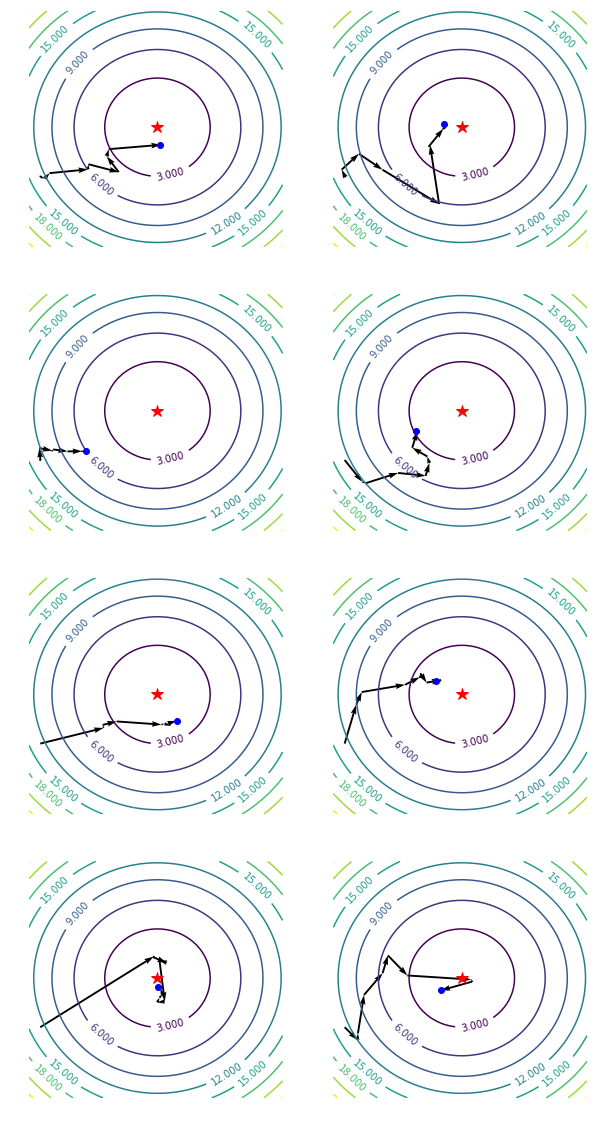

In [35]:

import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

num_trials = 8

w_est_overtrials = {str(i):None for i in range(num_trials)} # initialize

for tr in range(num_trials):
    
    # Generate new data.
    data_info = dp.NoisyOpt_isoBig()
    mod = mp.model(data_info)
    
    # "Run" the algorithm.
    al = Algo_SGD(w_init=w_init,\
                  batchsize=1,
                  delta=0.01,\
                  step=make_step(0.2),\
                  t_max=10,\
                  verbose=False,\
                  store=True)
    for mystep in al:
        al.update(model=mod)
        
    perf = mod.eval(al.w)
    print("Error:", perf)
    
    # Store the algorithm's output (the full trajectory).
    w_est_overtrials[str(tr)] = al.wstore
    

eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)
    
myfig = plt.figure(figsize=(10,20))

grididx = 1
for tr in range(num_trials):
    
    mypath = w_est_overtrials[str(tr)]
    
    ax = myfig.add_subplot(num_trials//2, 2, grididx)
    grididx += 1
    
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12)
    ax.plot(*mypath[:,-1], 'bo', markersize=6)
    ax.axis("off")

plt.show()


### Exercises:

1. Try setting $B=1$. With the same `step` and `t_max` settings, how do the three algoirithms (`FiniteDiff`, `GD`, `SGD`) compare in terms of their trajectories? It should evident that the search through parameter space is a lot "noisier" than the previous batch GD examples.

1. Try increasing `t_max` and decreasing the step size. Does the algorithm "stabilize"? Does it approach the desired solution?

1. Setting $B=1$, how does the average error and variance compare with the batch GD case? How does this change when step size is small and many iterations are done for `SGD`? At what level of $B$ does `SGD` effectively match `GD`?

1. Our default setting has the random index `shufidx` selected *without replacement*, i.e., `np.random.choice` is passed argument `replace=False`. Get a truly uniform sub-index, modify the code to do this *with* replacement. Does the performance change? If so, how?

1. (Bonus) At present, we compute the error using `al.w`, namely the parameter estimate $w_{(t)}$ after the final iteration. This is naturally sensitive to the final "jump" made. Instead, try computing performance for the average of the last five iterations (all past iterations are stored in `al.wstore`). This technique is an example of what is sometimes called $\alpha$-suffix averaging, and has been well-studied (Rakhlin et al., 2012).


### End of lesson: paste any routines to be re-used in the `scripts/AlgoIntro.py` file.

## References:

- P. Frey MA691 course notes, "The finite difference method". (https://www.ljll.math.upmc.fr/frey/ma691.html)
- Rakhlin, Alexander, Ohad Shamir, and Karthik Sridharan. "Making Gradient Descent Optimal for Strongly Convex Stochastic Optimization." ICML. 2012. arXiv URL: https://arxiv.org/abs/1109.5647